# Импорты библиотек

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
from datetime import datetime

# Чтение данных

In [ ]:
df_path = "marketplace.csv"

df = pd.read_csv(df_path)
display(df.head())
df.info()

# Чистка данных

## Преобразование типов

In [ ]:
df_cleaned = df.copy()

# df_cleaned = df_cleaned.astype({'reg_dt': int, 'first_buy': int, 'first_login': dt})

df_cleaned["reg_dt"] = pd.to_datetime(df_cleaned["reg_dt"], errors="coerce")
df_cleaned["first_buy"] = pd.to_datetime(df_cleaned["first_buy"], errors="coerce")
df_cleaned["first_login"] = pd.to_datetime(df_cleaned["first_login"], errors="coerce")

df_cleaned["user_id"] = df_cleaned["user_id"].apply(lambda x: int(x.strip("user_")))
df_cleaned["browser"] = df_cleaned["browser"].apply(lambda x: int(x.strip("browser_")))

## Заполнение нулей

In [ ]:
df_cleaned["first_buy"].fillna(df_cleaned[['first_login', 'reg_dt']].max(axis=1), inplace=True)

## Склеивание дублей и индексация по user_id

In [ ]:
df_cleaned = df_cleaned.groupby(by="user_id").agg(
    {
        "platform_num": "min",
        "first_login": "min",
        "reg_dt": "min",
        "browser": "min",
        "first_buy": "min",
        "target": "mean",
        "total_buy": "sum",
        "total_return": "sum",
    }
)
df_cleaned.head()

### Вспомогательные методы

In [ ]:
def shapiro_check(dataset, col, alpha=0.05):
    """
    Шапиро. Тест, является ли распределение СВ нормальным
    """
    stat, pvalue = st.shapiro(dataset[col].sample(n=3000))
    print('Шапиро')
    if pvalue > alpha:
        print(f'Данные {col} скорее всего распределены нормально\n')
    else:
        print(f'Данные {col} скорее всего распределены не нормально\n')

def kstest_check(dataset, col, alpha=0.05):
    """
    Колмогоров-Смирнов. Тест, является ли распределение СВ нормальным
    """
    arr = dataset[col]
    mu = arr.mean()
    sigma = arr.std(ddof=1)
    stat, pvalue = st.kstest(arr, 'norm', args=(mu, sigma))
    
    print('Колмогоров-Смирнов')

    if pvalue > alpha:
        print(f'Данные {col} скорее всего распределены нормально\n')
    else:
        print(f'Данные {col} скорее всего распределены не нормально\n')

def iqr_filter(dataset, col):
    """
    Фильтр по межквартильному р
    """
    medi = dataset[col].median()  
    Q1, Q3 = dataset[col].quantile([0.25, 0.75]) 
    IQR = Q3 - Q1
    
    bottom, top = medi - 1.5 * IQR, medi + 1.5 * IQR

    return dataset[(dataset[col] >= bottom) & (dataset[col] <= top)]

## Устраняем асинхронность в датах - дата первой покупки не должна быть меньше даты логина или регистрации

In [ ]:
df_cleaned.loc[(df_cleaned['reg_dt'] > df_cleaned['first_buy']), ['reg_dt']] = df_cleaned['first_buy']
df_cleaned.loc[(df_cleaned['first_login'] > df_cleaned['first_buy']), ['first_login']] = df_cleaned['first_buy']

## Проверить равенство дисперсий

## Убрать выбросы по межквартильному размаху

In [ ]:
df_cleaned_iqr = pd.DataFrame(data=df_cleaned)
df_cleaned_iqr = iqr_filter(df_cleaned_iqr, 'total_buy')

shapiro_check(df_cleaned_iqr, 'total_buy')
kstest_check(df_cleaned_iqr, 'total_buy')
shapiro_check(df_cleaned_iqr, 'total_return')
kstest_check(df_cleaned_iqr, 'total_return')

## Убрать выбросы по zscore

In [ ]:
df_zcore_filtered = pd.DataFrame(data=df_cleaned)

df_zcore_filtered = df_zcore_filtered[
    (abs(st.zscore(df_cleaned["total_buy"])) < 3)
    & (abs(st.zscore(df_cleaned["total_return"])) < 3)
]

shapiro_check(df_zcore_filtered, 'total_buy')
kstest_check(df_zcore_filtered, 'total_buy')
shapiro_check(df_zcore_filtered, 'total_return')
kstest_check(df_zcore_filtered, 'total_return')

In [ ]:
print('С фильтром по межквартильному размаху')
display(df_cleaned_iqr.describe())
print('С фильтром по z-score')
display(df_zcore_filtered.describe())

In [ ]:
st.probplot(df_cleaned_iqr['total_buy'], plot=plt)

plt.show()

## Выводы

# Гипотезы

### Рассмотрим следующие гипотезы:
 1. Влияние заранее зарегистрировавшихся пользователей (задолго до первого логина/покупки) и пользователей, которые произвели покупку до регистрации
 2. Таргет может влиять на покупки или наоборот
 3. Влияние браузера на прибыльность или на скорость покупки.
 4. Рассмотреть превалирирование определённого браузера/браузеров у юзеров, совершивших больше всего возвратов. 
 5. Аномальные всплески покупок/возвратов за весь период анализа. Привязка к другим данным? Праздникам?

# Стратегия проверки: Строим графики, смотрим результаты, считаем. Думаем. Повторяем. (кто-нибудь помогите с формулировкой, пожалуйста)


### Гипотеза №1 "Консервы"
_Влияние заранее зарегистрировавшихся пользователей и пользователей, которые произвели покупку до регистрации_   

На выдвижение данной гипотезы меня натолкнула идея построения графиков зависимостей всех трёх дат (регистрация, первый логин, первая покупка) попарно, в поисках аномалий.

In [ ]:
# обогащу таблицу разницей времени между тремя событиями
df_enriched = df_zcore_filtered.copy()

df_enriched["first_buy_reg_diff"] = (
    df_zcore_filtered["first_buy"] - df_zcore_filtered["reg_dt"]
).dt.days
df_enriched["first_login_buy_diff"] = (
    df_zcore_filtered["first_login"] - df_zcore_filtered["first_buy"]
).dt.days
df_enriched["first_login_reg_diff"] = (
    df_zcore_filtered["first_login"] - df_zcore_filtered["reg_dt"]
).dt.days
display(df_enriched.head(2))


In [ ]:
# Строим график зависимости дат регистрации и дат первой покупки
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["reg_dt"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_buy"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда регистрировались vs Когда купили")
plt.xlabel("Дата регистрации")
plt.ylabel("Дата первой покупки")
plt.legend()
plt.grid(True)
plt.show()


Видим аномальные отклонения от предсказуемой красной линии, есть объёмная группа юзеров, что регестрировались на протяжении всего периода, но покупки совершали в марте-апреле 2025. Это требует дополнительных исследований.

In [ ]:
# Строим график зависимости дат первого логина и дат первой покупки
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["first_login"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["first_login"].min()
max_date = df_enriched["first_buy"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда первый логин vs Когда купили")
plt.xlabel("Дата первого логина")
plt.ylabel("Дата первой покупки")
plt.legend()
plt.grid(True)
plt.show()


Тут, предварительно, не выводится надёжной визуальной зависимости. Вертикальная разряженная линия появилась из-за заполнения значений first_buy от reg_dt, который не учавствует в данном графике.   
Это, дополнительно, проверяется отстройкой подобного графика на неочищенных данных:
# Возможно лишний график стоит убрать, он вызовет вопросы, а я отвечаю на то, о чём нас и не спрашивали.
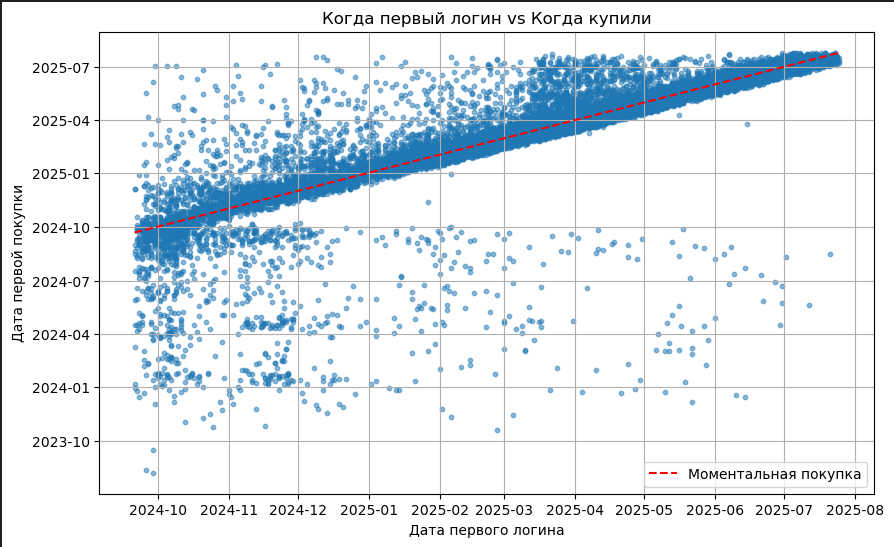

In [ ]:
# Строим график зависимости дат регистрации и дат первого логина
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["reg_dt"], df_enriched["first_login"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_login"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда регистрировались vs Когда первый логин")
plt.xlabel("Дата регистрации")
plt.ylabel("Дата первого логина")
plt.legend()
plt.grid(True)
plt.show()


Видим аномалию, аналогичную первому графику, соответственно регистрация была давно, а первая покупка и логин (если это одни и те же пользователи) произведены в марте-апреле 2025.   
Также заметен дополнительный аномальный интервал к концу 2024 года, также требующий анализа. 

Для проведения анализа планируется выборка клиентов с "лагом" в датах более ~30-50 дней и сравнение их финансового вклада по сравнению с остальными пользователями.

### Гипотеза №3 "Прибыльные браузеры"
### 3.1. "Скорость покупки по браузерам" — как быстро происходит первая покупка в каждом браузере (в среднем)


In [ ]:
# Если захотим убрать выбросы прежде чем считать среднее
# low = df_enriched["first_buy_reg_diff"].quantile(0.10)
# high = df_enriched["first_buy_reg_diff"].quantile(0.90)
# df_trimmed = df_enriched[
#     (df_enriched["first_buy_reg_diff"] >= low) &
#     (df_enriched["first_buy_reg_diff"] <= high)
# ]

avg_days_by_browser = (
    df_enriched
    .groupby("browser")["first_buy_reg_diff"]
    .mean()
    .reset_index()
    .sort_values("browser")
)
counts = df_enriched.groupby("browser")["first_buy_reg_diff"].count()
avg_days_by_browser["count"] = avg_days_by_browser["browser"].map(counts)

plt.figure(figsize=(12, 6))

plt.scatter(
    avg_days_by_browser["browser"],
    avg_days_by_browser["first_buy_reg_diff"],
    alpha=0.8,
    s=40
)

# Добавляем подписи рядом с точками
for _, row in avg_days_by_browser.iterrows():
    plt.text(
        row["browser"],
        row["first_buy_reg_diff"],
        f"{row['count']}",
        fontsize=9,
        ha='left',
        va='bottom'
    )

plt.xlabel("Browser")
plt.ylabel("Среднее число дней до первой покупки")
plt.title("Средняя скорость покупки по браузерам")
plt.grid(True)
plt.show()


Есть небольшие выбросы, но количество пользователей в них небольшое. Делаем вывод, что браузер не влияет на скорость первой покупки

### 3.2 Самые прибыльные браузеры

_Группируем покупки по браузерам, и рассчитываем среднюю прибыльность покупки на браузер:_
```sql
(SUM(total_buy) - SUM(total_return)) / COUNT_by_browser
```


In [ ]:
browser_profit = (
    df_enriched
    .groupby("browser")
    .agg(
        buy_sum=("total_buy", "sum"),
        return_sum=("total_return", "sum"),
        count=("browser", "count"),
    )
)

# Средняя прибыль на браузер
browser_profit["avg_profit"] = (browser_profit["buy_sum"] - browser_profit["return_sum"]) / browser_profit["count"]

# Сортировка по средней прибыли
browser_profit_sorted = browser_profit.sort_values("avg_profit", ascending=True)

plt.figure(figsize=(18, 6))

ax = browser_profit_sorted["avg_profit"].plot(
    kind="bar",
    color="skyblue",
    edgecolor="white",
)

plt.yscale("log")  # Логарифмическая шкала более очевидна из-за большой разницы между минимальной и максимальной прибыльностью

plt.title("Средняя прибыльность по браузерам (логарифмическая шкала)")
plt.xlabel("Browser ID")
plt.ylabel("Средняя прибыль (log шкала)")

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

Видны существенные различия в прибыльности каждой покупки в зависимости от браузера. Это можно использовать в таргетинге при запуске рекламных кампаний.

### Гипотеза №4 "Браузерные войны!"
_Предпочтения браузера у юзеров, совершивших больше всего покупок/возвратов._

Рассмотрим корреляцию используемых браузеров юзерами.

In [ ]:
# Для этого построим нормализованный график предпочтений пользователей по браузерам, отсортировав по дате первой покупки.

raw_counts = (
    df_enriched.groupby([df_enriched["first_buy"].dt.date, "browser"])
    .size()
    .unstack(fill_value=0)
)

normalized_df = raw_counts.div(raw_counts.sum(axis=1), axis=0) * 100

ax = normalized_df.plot(
    kind="bar",
    stacked=True,
    title="Доли браузеров по дням (Нормировано до 100%)",
    figsize=(20, 8),
    cmap="gist_ncar",
    width=1,
)

plt.xticks([])
plt.xlabel("=> Дата первой покупки =>")
plt.ylabel("Доля (%)")
plt.ylim(0, 100)


plt.legend(title="Browser ID", bbox_to_anchor=(1, 1), loc="upper left")
plt.show()


In [ ]:
# Для этого построим нормализованный график предпочтений пользователей по браузерам, отсортировав по дате первого логина.

raw_counts = (
    df_enriched.groupby([df_enriched["first_login"].dt.date, "browser"])
    .size()
    .unstack(fill_value=0)
)

normalized_df = raw_counts.div(raw_counts.sum(axis=1), axis=0) * 100

ax = normalized_df.plot(
    kind="bar",
    stacked=True,
    title="Доли браузеров по дням (Нормировано до 100%)",
    figsize=(20, 8),
    cmap="gist_ncar",
    width=1,
)

plt.xticks([])
plt.xlabel("=> Дата первого логина =>")
plt.ylabel("Доля (%)")
plt.ylim(0, 100)


plt.legend(title="Browser ID", bbox_to_anchor=(1, 1), loc="upper left")
plt.show()


Видна разница в графиках, в зависимости от того, от какой даты отталкиваться. Нужно дополнительно построить отдельно для пользователей с возвратами.
# Александр, можно это смерджить с третьим пунктом, а можно оставить как две отдельные гипотезы. Т.к. твоя основана на базе данных и выглядит интересной. Плюс довольно легко изначально описывается.

### Гипотеза №5 "Дружно все покупаем!"
_Аномальные всплески покупок/возвратов за весь период анализа._  
 
На выдвижение данной гипотезы меня натолкнула идея построения графика покупок/возвратов относительно даты первого логина.    
Этот график не покажет реальные даты всех покупок, так как общая сумма каждого клиента будет приложена к дате его первого логина, но может показать клиентов, кто внёс большой вклад, с привязкой к данной дате.

In [ ]:
df_enriched["period"] = df_enriched["first_login"].dt.to_period("W")

(
    df_enriched.groupby("period")[["total_buy", "total_return"]]
    .sum()
    .plot(
        kind="bar",
        title="Покупки и возвраты по клиентам, с разбивкой по неделям и привязкой к дате его первого логина",
        figsize=(15, 6),
        width=0.9,
    )
)
plt.legend(["Сумма покупок", "Сумма возвратов"])
plt.xlabel("Неделя первого логина")
plt.ylabel("Сумма покупок и возвратов")
plt.show()


По данному графику видим две аномалии, в сентябре 2024 года и в март-апреле 2025. Вторая корреклирует с гипотезой №1.    
Для анализа потребуется искать причины аномальной активности данных пользователей и корреляцию с гипотезой №1 для второй кагорты.